In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [257]:
# constants
V_0 = -5.0
R = 10.0
M = 50

x = np.linspace(-R, R, M+1)
delta = x[1] - x[0]

In [258]:
def V(x):
    return V_0 * np.exp(-x**2)

# functions in S_{3,2}
def psi(k, x_):
    if x_ >= x[k] - delta and x_ < x[k] + delta:
        return -1/delta**2 * (x_-x[k])**3 + (x_-x[k])
    else:
        return 0.0

def phi(k, x_):
    if x_ >= x[k] - delta and x_ < x[k] + delta:
        return -1/delta**2 * (x_-x[k])**2 + 1
    else:
        return 0.0

# second derivatives of these functions
def psi_xx(k, x_):
    if x_ >= x[k] - delta and x_ < x[k] + delta:
        return -6/delta**2 * (x_-x[k])
    else:
        return 0.0

def phi_xx(k, x_):
    if x_ >= x[k] - delta and x_ < x[k] + delta:
        return -2/delta**2
    else:
        return 0.0


# functions that form something like basis in S_{3,2}
def S(l, x_):
    if l == 0 or l == 2*M:
        return psi(l//2, x_)
    elif l % 2 == 1:
        return psi(int((l+1)/2), x_)
    else:
        return phi(int(l/2), x_)

# and their second derivatives
def S_xx(l, x_):
    if l == 0 or l == 2*M:
        return psi_xx(l//2, x_)
    elif l % 2 == 1:
        return psi_xx(int((l+1)/2), x_)
    else:
        return phi_xx(int(l/2), x_)

In [259]:
# collocation points
x_c = np.zeros(2*M)

x_c[::2] = x[:-1] + delta/2 - delta/2/np.sqrt(3)
x_c[1::2] = x[:-1] + delta/2 + delta/2/np.sqrt(3)

In [ ]:
A = np.zeros((2*M, 2*M))
B = np.zeros((2*M, 2*M))



In [260]:
def F(E):
    # building the matrix
    A = np.zeros((2*M, 2*M))
    
    for l in range(2*M):
        for t in [l-2, l-1, l, l+1, l+2]:
            if t < 2*M and t >=0:
                A[l,t] = -S_xx(l, x_c[t]) + V(x_c[t]) * S(l, x_c[t]) - E * S(l, x_c[t]) 
    
    return scipy.linalg.det(A)

-4.65
-3.3
-3.2
-1.0999999999999996
-1.0499999999999998
5


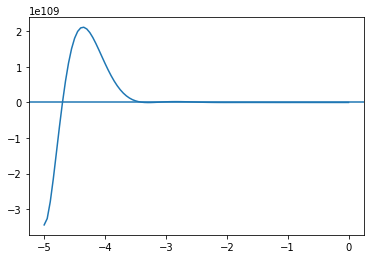

In [261]:
e = np.linspace(V_0,0.0,100+1)
det = np.zeros(len(e))
count = 0
spectrum = [None]

for i in range(len(e)):
    det[i] = F(e[i])
    if i>0 and (det[i]>0) != (det[i-1]>0):
        count += 1
        print((e[i]+e[i])/2)
    
plt.plot(e,det)
plt.axhline(y=0)
print(count)

In [62]:
def null(A, eps=1e-15):
    u, s, vh = np.linalg.svd(A)
    null_space = np.compress(s <= eps, vh, axis=0)
    return null_space.T

NameError: name 'A' is not defined